Contents of the file `cupy.singularity`:
~~~
Bootstrap: docker

#https://github.com/pytorch/pytorch#docker-image
From: docker://cupy/cupy:latest-python3

%post
    apt-get update
    apt-get install -y graphviz
    apt-get install -y cuda-toolkit-9-2
    pip3 install -U uproot
    pip3 install -U awkward
    pip3 install -U jupyter
    pip3 install -U matplotlib
    pip3 install -U dask
    pip3 install -U distributed
    pip3 install -U graphviz
    pip3 install -U numba

#can be empty
%environment
    JUPYTER_RUNTIME_DIR=$HOME/jupyter-runtime

%runscript
    /bin/bash
~~~

Compile as `sudo singularity build cupy.simg cupy.singularity`.

Run as `JUPYTER_DATA_DIR=/tmp/$USER/jupyter LC_ALL=C singularity exec -B /data -B /nvmedata --nv $SINGULARITY_IMAGE jupyter notebook --certfile $HOME/mycert.pem --keyfile $HOME/mykey.key --ip 0.0.0.0 --port $PORT`.

On `titans.hep.caltech.edu`, the image is in `/nfshome/singularity/images/cupy.simg`.

In [1]:
#!pip3 install -U pyarrow

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import uproot, cupy, awkward
from awkward.util import numpy as anp
import numpy as np
import dask
import glob
import psutil, os
from collections import OrderedDict
from typing import List, Dict
import math
import numba
import pyarrow

os.environ["NUMBAPRO_NVVM"] = "/usr/local/cuda-9.2/nvvm/lib64/libnvvm.so"
os.environ["NUMBAPRO_LIBDEVICE"] = "/usr/local/cuda-9.2/nvvm/libdevice/"
from numba import cuda

/usr/local/lib/python3.5/dist-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [4]:
!nvidia-smi

Thu Mar 21 14:37:43 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.26                 Driver Version: 396.26                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:07:00.0 Off |                  N/A |
| 26%   58C    P8    30W / 250W |      0MiB / 12210MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
awkward.__version__, cupy.__version__, numba.__version__

('0.8.11', '6.0.0a1', '0.43.0')

In [6]:
infile = '/nvmedata/store/mc/RunIIFall17NanoAOD/GluGluHToMuMu_M125_13TeV_amcatnloFXFX_pythia8/NANOAODSIM/PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/20000/0C2B3A66-B042-E811-8C6D-44A8423DE2C0.root'

In [7]:
arrays_ev = [
    "PV_npvsGood", "Flag_METFilters", "Flag_goodVertices", "Generator_weight", "genWeight", "HLT_IsoMu24"
]
arrays_jet = [
    "Jet_pt", "Jet_eta", "Jet_phi", "Jet_btagDeepB", "Jet_jetId"
]

arrays_muon = [
    "nMuon", "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", "Muon_pfRelIso03_all", "Muon_mediumId", "Muon_charge"
]

arrays_to_load = arrays_jet + arrays_muon

In [8]:
arrays_gen = [
    "GenPart_pt", "GenPart_eta", "GenPart_phi", "GenPart_mass", "GenPart_pdgId", "GenPart_status"
]

In [9]:
fi = uproot.open(infile)
tt = fi.get("Events")
arr = tt.array("Jet_pt")

In [10]:
len(arr)

1279071

In [11]:
arr

<JaggedArray [[98.0625 65.9375 23.46875 19.21875 18.359375 15.796875] [41.1875 21.34375 21.171875 18.8125 18.078125 16.421875] [69.5625 64.4375 28.078125 17.75] ... [81.625 76.5 32.53125 ... 18.609375 16.9375 15.6796875] [133.75 75.625 48.75 ... 25.578125 21.921875 17.984375] [139.625 87.8125 45.3125 ... 15.6640625 15.046875 15.015625]] at 0x7f15538a9320>

In [12]:
for idx in range(10):
    print("event=", idx, " njet=", len(arr[idx]), " jets_pt=", arr[idx], sep='')

event=0 njet=6 jets_pt=[98.0625   65.9375   23.46875  19.21875  18.359375 15.796875]
event=1 njet=6 jets_pt=[41.1875   21.34375  21.171875 18.8125   18.078125 16.421875]
event=2 njet=4 jets_pt=[69.5625   64.4375   28.078125 17.75    ]
event=3 njet=4 jets_pt=[87.5625    37.40625   16.375     15.6328125]
event=4 njet=5 jets_pt=[82.       76.625    37.125    24.84375  15.046875]
event=5 njet=7 jets_pt=[77.8125   71.875    66.625    34.53125  19.640625 18.734375 15.40625 ]
event=6 njet=4 jets_pt=[88.8125  70.0625  42.15625 24.0625 ]
event=7 njet=6 jets_pt=[78.3125    61.75      19.140625  15.75      15.6484375 15.234375 ]
event=8 njet=4 jets_pt=[89.3125   43.03125  27.875    19.140625]
event=9 njet=5 jets_pt=[68.3125    60.40625   22.21875   19.78125   15.2265625]


Text(0, 0.5, 'number of events')

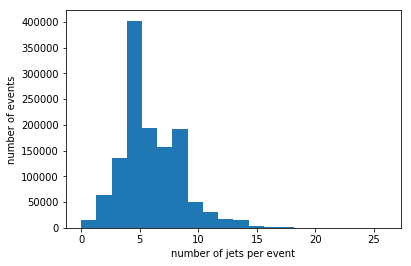

In [13]:
plt.hist(arr.counts, bins=20);
plt.xlabel("number of jets per event")
plt.ylabel("number of events")

In [14]:
num_total_dense = len(arr) * np.max(arr.counts)
num_total_dense

33255846

In [15]:
num_total_sparse = len(arr.content)
num_total_sparse

7590616

In [16]:
num_total_sparse / num_total_dense

0.2282490723585862

In [17]:
muon_charges = tt.array("Muon_charge")

In [18]:
muon_charges

<JaggedArray [[1 -1] [1] [1 -1] ... [1 -1] [1 -1] [1 -1]] at 0x7f1552de1f28>

In [19]:
muon_charges.content

array([ 1, -1,  1, ..., -1,  1, -1], dtype=int32)

In [20]:
muon_charges.offsets

array([      0,       2,       3, ..., 2284275, 2284277, 2284279])

In [21]:
from collections import Counter
Counter(muon_charges.counts)

Counter({0: 44125,
         1: 272512,
         2: 881660,
         3: 75040,
         4: 5366,
         5: 347,
         6: 20,
         8: 1})

In [22]:
#naive implementation in pure Python
def get_os_muons_slow(muon_charges, out_mask):
    for ic, _c in enumerate(muon_charges):
        
        if _c.shape[0] >= 2:
            
            #find next muon that has an opposite charge, break
            for isecond in range(1, len(_c)):
                if _c[isecond] != _c[0]:
                    
                    #always take the first (leading pt) muon
                    out_mask[ic][0] = True
                    
                    out_mask[ic][isecond] = True
                    break
                
    return

In [23]:
@numba.jit(nopython=True)
def get_os_muons_numba(muon_charges_content, muon_charges_offsets, muon_mask_out):
    for iev in range(len(muon_charges_offsets) - 1):
        start = muon_charges_offsets[iev]
        end = muon_charges_offsets[iev + 1]
        
        if end-start >= 2:
            ch1 = muon_charges_content[start]
            for imuon in range(start+1, end):
                ch2 = muon_charges_content[imuon]
                if ch2 != ch1:
                    muon_mask_out[start] = True
                    muon_mask_out[imuon] = True
                    break
    return

In [24]:
@cuda.jit('void(int8[:], int64[:], int8[:])')
def get_os_muons_cuda(muon_charges_content, muon_charges_offsets, muon_mask_out):
    xi = cuda.grid(1)
    xstride = cuda.gridsize(1)
    
    for iev in range(xi, muon_charges_offsets.shape[0]-1, xstride):
        start = muon_charges_offsets[iev]
        end = muon_charges_offsets[iev + 1]
        
        ch1 = muon_charges_content[start]
        
        for imuon in range(start+1, end):
            ch2 = muon_charges_content[imuon]
            if (ch2 != ch1):
                muon_mask_out[start] = 1
                muon_mask_out[imuon] = 1
                break
    return

In [25]:
def get_os_muons_awkward(muon_charges, out_muon_mask):

    ch = muon_charges
        
    #select events with at least 2 muons
    events_min2_muons = ch.count()>=2
    
    #get the charges of the muons in these events
    ch2 = ch[events_min2_muons]

    #get the index pairs of all muons on an event-by-event basis
    all_muon_pairs = ch2.argcross(ch2)

    #get only those index pairs where the muon is not paired with itself and is paired with another muon with a higher index
    pairs_mask = (all_muon_pairs['0'] != all_muon_pairs['1']) & ((all_muon_pairs['0'] < all_muon_pairs['1']))
    all_muon_pairs = all_muon_pairs[pairs_mask]
    
    #get the pairs with the opposite sign charges
    pairs_with_os = ch2[all_muon_pairs['0']] != ch2[all_muon_pairs['1']]
    
    #get the indices of the pairs with the opposite sign
    idxs = all_muon_pairs[pairs_with_os]

    #get the events that had at least one such good pair
    events_min1_os_pair = idxs['0'].count()>=1
    idxs2 = idxs[events_min1_os_pair]
    bestpair = idxs2[:, 0]
    
    first_muon_idx = bestpair['0']
    second_muon_idx = bestpair['1']

    #set the leading and subleading muons to pass the mask according to the pair
    muon_mask_active = out_muon_mask[events_min2_muons][events_min1_os_pair]
    muon_mask_active.content[muon_mask_active.starts + first_muon_idx] = True
    muon_mask_active.content[muon_mask_active.starts + second_muon_idx] = True
    
    return

In [26]:
mu_c = cupy.array(muon_charges.content, dtype=np.int8)
mu_o = cupy.array(muon_charges.offsets, dtype=np.int64)

mask_cuda = cupy.zeros_like(mu_c, dtype=np.int8)
mask_numba = np.zeros_like(muon_charges.content, dtype=np.int8)

mask_awkward = awkward.array.jagged.JaggedArray(
    muon_charges.starts,
    muon_charges.stops,
    np.zeros(shape=muon_charges.content.shape, dtype=bool)
)

mask_slow = mask_awkward.copy()

In [27]:
timing_python = %timeit -o get_os_muons_slow(muon_charges, mask_slow)
timing_python

8.69 s ± 46.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 8.69 s ± 46.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [28]:
timing_cuda = %timeit -n10 -o get_os_muons_cuda[128,1024](mu_c, mu_o, mask_cuda);cuda.synchronize()
timing_cuda

509 µs ± 99.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 509 µs ± 99.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [29]:
np.all(np.equal(cupy.asnumpy(mask_cuda), mask_slow.content))

True

In [30]:
timing_numba = %timeit -n10 -o get_os_muons_numba(muon_charges.content, muon_charges.offsets, mask_numba)
timing_numba

7.51 ms ± 4.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 7.51 ms ± 4.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [31]:
np.all(np.equal(cupy.asnumpy(mask_cuda), mask_numba))

True

In [32]:
timing_awkward = %timeit -n10 -o get_os_muons_awkward(muon_charges, mask_awkward)

1.9 s ± 17.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
np.all(np.equal(cupy.asnumpy(mask_cuda), mask_awkward.content))

True

In [34]:
avgs = []
stddevs = []
for t in [timing_python, timing_awkward, timing_numba, timing_cuda]:
    avgs += [t.average]
    stddevs += [t.stdev]
    
avgs = np.array(avgs)
stddevs = np.array(stddevs)

normfactor = len(muon_charges)

Text(0.5, 1.0, 'Events processed: 1.28E+06')

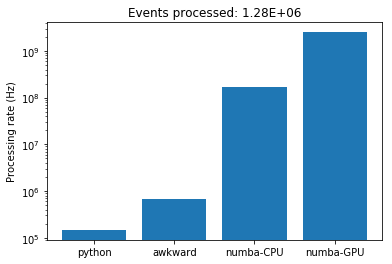

In [36]:
plt.bar(range(len(avgs)), normfactor/avgs)
plt.yscale("log")
plt.xticks(range(4), ["python", "awkward", "numba-CPU", "numba-GPU"])
plt.ylabel("Processing rate (Hz)")
plt.title("Events processed: {0:.2E}".format(normfactor))

In [37]:
muon_mask_opposite_sign = awkward.array.jagged.JaggedArray(
    muon_charges.starts,
    muon_charges.stops,
    cupy.asnumpy(mask_cuda).view(dtype=bool)
)

In [38]:
#check if we selected only opposite sign muons
selected_charges = muon_charges[muon_mask_opposite_sign]

In [39]:
selected_charges

<JaggedArray [[1 -1] [] [1 -1] ... [1 -1] [1 -1] [1 -1]] at 0x7f1552b388d0>

In [40]:
arrs = tt.arrays([b"Muon_pt", b"Muon_eta", b"Muon_phi", b"Muon_tightId", b"Muon_charge"])

In [44]:
class JaggedStruct(object):
    def __init__(self, offsets, attrs_data, numpy_lib=np):
        self.numpy_lib = numpy_lib
        
        self.offsets = offsets
        self.attrs_data = attrs_data
        
        num_items = None
        for (k, v) in self.attrs_data.items():
            num_items_next = len(v)
            if num_items and num_items != num_items_next:
                raise AttributeError("Mismatched attribute {0}".format(k))
            else:
                num_items = num_items_next
            setattr(self, k, v)
    
        self.mask = self.numpy_lib.ones(num_items, dtype=self.numpy_lib.int8)
        
    @staticmethod
    def from_arraydict(arraydict, prefix, numpy_lib=np):
        ks = [k for k in arraydict.keys() if prefix in str(k, 'ascii')]
        k0 = ks[0]
        return JaggedStruct(
            numpy_lib.array(arraydict[k0].offsets),
            {str(k, 'ascii').replace(prefix, ""): numpy_lib.array(v.content)
             for (k,v) in arraydict.items()},
            numpy_lib=numpy_lib
        )

In [65]:
@cuda.jit('void(int32[:], int64[:], int8[:])')
def select_opposite_sign_muons_cudakernel(muon_charges_content, muon_charges_offsets, muon_mask_out):
    xi = cuda.grid(1)
    xstride = cuda.gridsize(1)
    
    for iev in range(xi, muon_charges_offsets.shape[0]-1, xstride):
        start = muon_charges_offsets[iev]
        end = muon_charges_offsets[iev + 1]
        
        ch1 = muon_charges_content[start]
        
        for imuon in range(start+1, end):
            ch2 = muon_charges_content[imuon]
            if (ch2 != ch1):
                muon_mask_out[start] = 0
                muon_mask_out[imuon] = 0
                break
    return


@cuda.jit('void(int8[:], int64[:], int8[:])')
def sum_in_event(content, offsets, out):
    xi = cuda.grid(1)
    xstride = cuda.gridsize(1)

    for iev in range(xi, offsets.shape[0]-1, xstride):
        start = offsets[iev]
        end = offsets[iev + 1]
        for ielem in range(start, end):
            out[iev] += content[ielem]

def select_muons_opposite_sign(muons, mask_name=None):
    if not mask_name:
        select_opposite_sign_muons_cudakernel[32,1024](muons.charge, muons.offsets, muons.mask)
    else:
        mask = muons.numpy_lib.ones_like(muons.mask)
        select_opposite_sign_muons_cudakernel[32,1024](muons.charge, muons.offsets, mask)
        setattr(muons, mask_name, mask)
        
def select_muons_pt(muons, ptcut, mask_name=None):
    if not mask_name:
        muons.mask = muons.mask & (muons.pt > ptcut)
    else:
        setattr(muons, mask_name, muons.pt > ptcut)

In [46]:
muons = JaggedStruct.from_arraydict(arrs, "Muon_", cupy)
select_muons_pt(muons, 30, "mask_subleading")
select_muons_pt(muons, 30, "mask_leading")

In [47]:
muons.mask_subleading
muons.mask_leading

array([ True,  True,  True, ..., False,  True,  True])

In [62]:
sum_out = cupy.zeros_like(muons.offsets, dtype=cupy.int8)
%timeit sum_in_event[128, 1024](muons.mask_subleading, muons.offsets, sum_out);numba.cuda.synchronize()

539 µs ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [56]:
awkward.JaggedArray.fromoffsets?

In [58]:
mask_sl =awkward.JaggedArray.fromoffsets(
    cupy.asnumpy(muons.offsets),
    cupy.asnumpy(muons.mask_subleading),
)

In [60]:
%timeit mask_sl.sum()

22.9 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
